# Number Partition problem with QAOA

The number partition problems consists of partitioning a given set $S$ into two subsets $S_{1}$ and $S_{2}$ such that the difference between sums $ \delta = |\sum S_{1} - \sum S_{2}|$ is minimal. This problem can be thought of an optimization task in which $\delta$ is a variable to be minimized.

We approach this problem by making use of the Quantum Approximate Optimization algorithm (QAOA) [1]. To do so, we construct an effective cost function for the number partition problem in terms of a quantum Ising Hamiltonian [2]

\begin{equation}
H_{C} = \Big( \sum_{i} n_{i} \sigma^{z}_{i} \Big)^{2},
\end{equation}

where $\sigma^{z}$ is the $z$ Pauli matrix and $n_{i}$ are the elements of the set $S$ we want to partition. The number of elements $N$ in the set determines the number of spins in the Hamiltonian. The square power in the Hamiltonian ensures that all eigenvalues satisfy $E_{i} \geq 0$. Naturally, this Hamiltonian partitions the elements $n_{i}$ into two classes, associated with spins pointing up or down. Hence, the task of partitioning the set $S$ such that $\delta$ is minimized can be reduced to finding the ground state of $H_{C}$. Note that if there exists a perfect partition such that $\delta = 0$, this is equivalent to a ground state with $E_{\textrm{gs}} = 0$. 

We then resort to QAOA to find the ground state of $H_{C}$. In short, this amounts to generating a variational ansatz of the form

\begin{equation}
| \vec{\gamma},\vec{\beta} \rangle = \prod_{i}^{p} e^{-i\beta_{p} H_{B}} e^{-i\gamma_{p} H_{C}} |+ \rangle^{ \otimes N},
\end{equation}

where $H_{B} = \sum_{i} \sigma_{i}^{x}$, with $\sigma_{i}^{x}$ the $x$ Pauli matrix, is a mixing Hamiltonian associated with a uniform magnetid field is the $x$ direction and $\vec{\gamma} = (\gamma_{1},\ldots, \gamma_{p})$ and $\vec{\beta} = (\beta_{1}, \ldots, \beta_{p})$ are a set of $2p$ parameters which need to be classically optimized such that the state $| \vec{\gamma},\vec{\beta} \rangle$ minimizes the energy expectation value $F = \langle \vec{\gamma},\vec{\beta} |H_{C}| \vec{\gamma},\vec{\beta} \rangle$. We refer to $p$ as the number of times we apply the pair of unitaries, denoted layers. The $|+ \rangle$ state corresponds to the eigenstate of $\sigma^{x}$, with $\sigma^{x} |+\rangle = |+\rangle$, which in the computational basis is defined as $|+\rangle  = \frac{|0\rangle + |1 \rangle  }{\sqrt{2}}$.

To optimize $\vec{\gamma}$ and $\vec{\beta}$, we need a good initial guess to trigger the classical optimization algorithm. This is crucial as otherwise we can get stuck in suboptimal minima. We choose an initial guess for the parameters by performing a grid search in parameter space [3]. The search is performed layer by layer and at each layer we keep the parameters that yield the smallest energy and fix them to scan the next layer. One is encouraged to choose a larger amount of grid points in the $\gamma$ direction as $H_{C}$ is likely to generate many more different energy scales as we increase the system size, thus making $F$ to be more rapidly varying in this direction.

In the following, we use our code to solve the number partition problem using QAOA. We first provide a fleshed out test, then discuss the effects of increasing the number of layers and varying the other parameters. We conclude with some remarks regarding improving the performance of the code. Before proceeding, let us make a few remarks about convention in our code:

- The Ising Hamiltonian is recasted as $H_{C} = \sum_{i \leq j} J_{ij} \sigma_{i}^{z} \sigma_{j}^{z}$ with $J$ an upper triangular matrix satisfying $J_{ij} = 2n_{i}n_{j}$ for $i \neq j$ and $J_{ii} = n_{i}^{2}$ for $i = j$.


- The mixing Hamiltonian $H_{B}$ follows the convention of [1], with an overall plus sign in front.


- Since the elements of $S$ are integers, we can restrict the angles $\gamma_{p} \in (0, \pi)$, due to $e^{-i \pi H_{C}} = \mathbb{1}$ if $\sum S$ even or  $e^{-i \pi H_{C}} = (\sigma^{z})^{\otimes N}$ if $\sum S$ odd.


- Since the Ising Hamiltonian $H_{C}$ exhibits a $\mathbb{Z}_{2}$ symmetry, the value of the angles $\beta_{p}$ are restricted to $\beta_{p} \in (0, \frac{\pi}{2})$ [4].


Refs.:

[1] E. Farhi et al, A Quantum Approximate Optimization Algorithm, arXiv:1411.4028

[2] A. Lucas, Ising formulations of many NP problem, Front. Phys., 12 Feb. 2014

[3] A. H. Karamlou et al, Analyzing the Performance of Variational Quantum Factoring on a Superconducting Quantum Processor, arXiv:2012.07825

[4] L. Zhou et al, Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices, Phys. Rev. X 10, 021067 (2020)



### *Importing files*

In [1]:
from number_partition_qaoa import *

# Fleshed out test

We start by considering a set S 

In [2]:
S = [1,2,3]

The script contains a function to extract the defining properties of the Hamiltonian $H_{C}$ associated with the set $S$. This corresponds to a list of edges connecting the spins (note that there will be an edge for each pair of spins as the system is all-to-all interacting, i.e. fully connected!), and the upper triangular matrix $J$ containing all interaction strengths

In [3]:
E,J = fully_connected_model(S)

print('The edges in the problem are {}'.format(E))
print('The interaction matrix in the problem is {}'.format(J))

The edges in the problem are [[0, 1], [0, 2], [1, 2]]
The interaction matrix in the problem is [[1, 4, 6], [0, 4, 12], [0, 0, 9]]


To tackle the full QAOA problem, the script contains a specific class *number_partition_qaoa()*, of which we create an instance using the variables we just created

In [4]:
test1 = number_partition_qaoa(S,E,J)

Before launching the QAOA, we can do a quick sanity check by calling the *states_and_energies()* method, which returns a dictionary with all the possible spin configurations for this model and their associated energies (we can only do this because the problem size is fairly small!)

In [5]:
test1.states_and_energies()

{'000': 36,
 '001': 0,
 '010': 4,
 '011': 16,
 '100': 16,
 '101': 4,
 '110': 0,
 '111': 36}

As expected these energies satisfy what we expect from the definition of the Ising Hamiltonian $H_{C}$ presented above. 

We are now ready to start the QAOA process using the *run_qaoa()* method. To do so, we need to define a few hyperparameters that determine how the algorithm is run. First, the number of layers that we want out ansatz to have, i.e. the number of total parameters we want to consider. Second, the number of samples we take when running the circuit during classical optimization and when computing the final answer. Next, the *run_qaoa()* method allows to choose the number of times to run the circuit at each grid point and the size of the grid in the $\gamma$ and $\beta$ directions. We can also decide whether we want it to print a list with all the measured states. Lastly, we can choose to use a QPU to find the final solution to the problem once the parateres are optimized.

The class has default values for all parameters except for the number of layers. These are: num_samples = 20000, grid_num_samples = 2000, grid_size = [80,20], show_states = False, use_qpu = False. By default, the class is run on the IBM 'qasm-simulator'. It also uses by default the Nelder-Mead algorithm as a classical optimizer.

In [6]:
# Let's try first the simplest case of a single layer with default values!

# Number of layers
p = 1

# Number of samples when optimizing and computing answer
num_samples = 20000

#Number of samples for grid search
grid_num_samples = 2000

# Size of grid
grid_size = [80,20]

show_states = True
use_qpu = False

s1, s2, outcomes = test1.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 0min 19s     

Optimization seed parameters: γ = [0.982], β = [0.707] - E = 1.68


Initiating QAOA parameter optimization

Optimization took 0min 24s 

Running QAOA with optimal parameters...

Solution:    Energy = 1.0818 

Parameters:   γ = 0.964     β = 0.669   (p=1)

State: |001>   Probability: 43.64% 

State: |110>   Probability: 43.42% 

State: |101>   Probability: 4.79% 

State: |010>   Probability: 4.58% 

State: |011>   Probability: 1.45% 

State: |100>   Probability: 1.45% 

State: |111>   Probability: 0.35% 

State: |000>   Probability: 0.33% 

The final answer is state |001> 


The set can be split in two sets: 

S1 = [1, 2]
S2 = [3] 

with minimal difference | ∑ S1 - ∑ S2 | = 0


Here we purposedly chose the list of measured states to be displayed. As we can see, our algorithm correctly partitioned the set already using only a single layer and all of the default values. Note that as a result of the $\mathbb{Z}_{2}$ symmetry of the Hamiltonian, there are two equivalent answers, which here amount to 87% of the results.

### Using QPU

For completeness let us now repeat the same experiment, but using a QPU instead. In that case the number of times we run the circuit is bounded by the capacity of the hardware. Thus, along with a choice of QPU, the script will ask for the number of times we want to run the experiment.

In [8]:
# Load personal IBM account
IBMQ.load_account()

p = 1
num_samples = 20000
grid_num_samples = 2000
grid_size = [80,20]
show_states = True
use_qpu = True

s1, s2, outcomes = test1.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Grid search has taken 0min 25s     

Optimization seed parameters: γ = [0.982], β = [0.707] - E = 1.602


Initiating QAOA parameter optimization

Optimization took 0min 29s 

Running QAOA with optimal parameters...

Insert the name of qpu to be used, e.g. 'ibmq_athens'
ibmq_athens

Number of shot samples wanted (needs to be smaller than 8192):
4096

Executing QPU
Job id: 605cbf331b50b1644525ca6d
Job Status: job has successfully run
Solution:    Energy = 5.26953125 

Parameters:   γ = 0.965     β = 0.68   (p=1)

State: |110>   Probability: 33.2% 

State: |001>   Probability: 29.71% 

State: |010>   Probability: 11.57% 

State: |101>   Probability: 7.71% 

State: |100>   Probability: 5.83% 

State: |000>   Probability: 5.05% 

State: |011>   Probability: 3.71% 

State: |111>   Probability: 3.2% 

The final answer is state |110> 


The set can be split in two sets: 

S1 = [3]
S2 = [1, 2] 

with minimal difference | ∑ S1 - ∑ S2 | = 0


As we can see, using the QPU we can effectively compute the correct answer. Of course, the percentage of success will likely decrease when compared with the simulator as the real hardware is subject to many different sources of noise, which add to the much smaller number of runs we can perform on it. On top that, it is important to keep in mind that the Ising Hamiltonian corresponding the number partition problem is particularly non-friendly to the current IBM hardware. This follows from $H_{C}$ being an all-to-all interacting problem, while no such device contains such great connectivity, which can add a great number of extra gates that need to be performed to swap the qubits around, along with its corresponding noise contribution.

The use of QPU in the main script has only been implemented as the last step of the algorithm, due to the sometimes very long waiting times in queue which would make the grid search and the classical optimization process very slow. For reference, if the set we want to partition has more than 5 elements, the script will default to the imbq_16_melbourne chip, as this is the only device which allows for more than 5 qubits.

## Number of layers

We now consider a different example and explore the effect of using more layers. We run the algorithm three times for thr values $p=1,2,3$

In [12]:
# Define set, obtain properties
S = [1,3,3,5]
E, J = fully_connected_model(S)

# Define new instance
test2 = number_partition_qaoa(S,E,J)

# Number of layers
p = 1

# Number of samples when optimizing and computing answer
num_samples = 20000

#Number of samples for grid search
grid_num_samples = 2000

# Size of grid
grid_size = [80,20]

show_states = True
use_qpu = False

s1, s2, outcomes = test2.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 0min 32s     

Optimization seed parameters: γ = [2.16], β = [1.021] - E = 12.38


Initiating QAOA parameter optimization

Optimization took 0min 35s 

Running QAOA with optimal parameters...

Solution:    Energy = 9.8282 

Parameters:   γ = 2.164     β = 1.033   (p=1)

State: |1001>   Probability: 36.4% 

State: |0110>   Probability: 34.94% 

State: |1010>   Probability: 5.24% 

State: |0011>   Probability: 4.96% 

State: |0101>   Probability: 4.76% 

State: |1100>   Probability: 4.69% 

State: |0000>   Probability: 1.8% 

State: |1111>   Probability: 1.72% 

State: |0001>   Probability: 1.12% 

State: |1110>   Probability: 1.1% 

State: |1101>   Probability: 0.73% 

State: |0100>   Probability: 0.69% 

State: |0010>   Probability: 0.68% 

State: |1011>   Probability: 0.62% 

State: |0111>   Probability: 0.27% 

State: |1000>   Probability: 0.27% 

The final answer is state |1001> 


The set can be split in two sets: 

S1 = [3, 3]
S2 = [1, 5] 

with minimal diffe

In [15]:
# Number of layers
p = 2

# Number of samples when optimizing and computing answer
num_samples = 20000

#Number of samples for grid search
grid_num_samples = 2000

# Size of grid
grid_size = [80,20]

show_states = True
use_qpu = False

s1, s2, outcomes = test2.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 0min 52s     

Optimization seed parameters: γ = [1.414, 1.532], β = [0.079, 0.55] - E = 10.618


Initiating QAOA parameter optimization

Optimization took 1min 2s 

Running QAOA with optimal parameters...

Solution:    Energy = 7.1892 

Parameters:   γ = 1.406     β = 0.082   (p=1)
              γ = 1.542     β = 0.53   (p=2)

State: |0110>   Probability: 35.69% 

State: |1001>   Probability: 35.61% 

State: |1010>   Probability: 4.98% 

State: |0101>   Probability: 4.78% 

State: |1100>   Probability: 4.74% 

State: |0011>   Probability: 4.72% 

State: |1110>   Probability: 1.61% 

State: |0001>   Probability: 1.52% 

State: |0010>   Probability: 1.21% 

State: |1101>   Probability: 1.16% 

State: |1011>   Probability: 1.05% 

State: |0100>   Probability: 1.04% 

State: |0000>   Probability: 0.6% 

State: |1111>   Probability: 0.54% 

State: |1000>   Probability: 0.38% 

State: |0111>   Probability: 0.35% 

The final answer is state |0110> 


The set can be spli

In [14]:
# Number of layers
p = 3

# Number of samples when optimizing and computing answer
num_samples = 20000

#Number of samples for grid search
grid_num_samples = 2000

# Size of grid
grid_size = [80,20]

show_states = True
use_qpu = False

s1, s2, outcomes = test2.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 1min 23s     

Optimization seed parameters: γ = [0.0, 2.16, 1.374], β = [1.021, 0.864, 0.314] - E = 2.738


Initiating QAOA parameter optimization

Optimization took 1min 44s 

Running QAOA with optimal parameters...

Solution:    Energy = 0.4282 

Parameters:   γ = 0.0     β = 1.032   (p=1)
              γ = 2.159     β = 0.918   (p=2)
              γ = 1.37     β = 0.306   (p=3)

State: |0110>   Probability: 49.38% 

State: |1001>   Probability: 48.38% 

State: |0101>   Probability: 0.4% 

State: |1100>   Probability: 0.4% 

State: |1010>   Probability: 0.34% 

State: |0011>   Probability: 0.29% 

State: |1110>   Probability: 0.27% 

State: |0001>   Probability: 0.24% 

State: |0100>   Probability: 0.08% 

State: |1011>   Probability: 0.07% 

State: |1101>   Probability: 0.05% 

State: |1111>   Probability: 0.04% 

State: |0010>   Probability: 0.03% 

State: |0000>   Probability: 0.02% 

State: |0111>   Probability: 0.01% 

State: |1000>   Probability: 0.01% 



Let us summarize the what we observe here: in all cases the algorithm is able to partition the set correctly (as expected for a such small set), for $p=1$ the frequency of the correct answer is about 71%, for $p=2$ the frequency barely changes and is again of about 71%, for $p=3$ the frequency of the correct answer is greatly enhanced to roughly 98%. 

An increase in accuracy is to be expected given that a higher complexity in the ansatz allows for a better expressibility of the ground state. For $p \rightarrow \infty$, it is expected that QAOA will perfectly optimize the given problem. Thus, computing power permitting, the more layers we use, the more likely it is we will measure our correct answer with higher frequency.

Now, why is it that when increasing from one to two layers we obtain the same result? That can be understood if we think about the way we optimize the angles and the effect of the other hyperparameters. We rely on the capability of grid searching to obtain a good seed for the optimizer. Nevertheless, the quality of our initial guess strongly depends on the grid size and the amount of samples we consider at each grid point. On one hand, the bigger the grid size, the more points we can explore and thus we will be more likely to bump into a region closer to the optimal solution. On the other hand, the more number of samples that we take at each grid point, will allow for a better estimate of the actual expectation value of the energy at that point. Too small of a grid size and we might end up exploring a suboptimal area. Too small of a number of samples at each grid point and we will not be estimating accurately what is the region we are exploring. 

Thus, in the particular run we considered for $p=2$ we simply happened to obtain the same result as in for $p=1$, but by repeating the run a few times, it is possible to see an increase in the answer frequency. Note that when increasing the number of layers (i.e. the complexity), the grid search is also more prone to errors as we are left with the task of exploring a much larger parameter space. When exploring high values of $p$ it is then advisable to play around with the different hyperparameters to find the optimal result.

# Other examples

Here we show some extra examples in where the algorithm is capable of correctly partitioning the sets. Feel free to add more cells and try your own! :)

In [19]:
# Define set, obtain properties
S = [4,5,6,7,8]
E,J = fully_connected_model(S)

# Define new instance
test3 = number_partition_qaoa(S,E,J)

# Number of layers
p = 3

# Number of samples
num_samples = 20000

# Grid search properties
grid_num_samples = 5000
grid_size = [80,30]

# Print states
show_states = True

# Use classical simulator
use_qpu = False

s1, s2, outcomes = test3.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 4min 34s     

Optimization seed parameters: γ = [2.042, 2.081, 0.393], β = [0.733, 0.471, 0.524] - E = 77.2728


Initiating QAOA parameter optimization

Optimization took 1min 57s 

Running QAOA with optimal parameters...

Solution:    Energy = 73.2408 

Parameters:   γ = 2.031     β = 0.755   (p=1)
              γ = 2.084     β = 0.472   (p=2)
              γ = 0.392     β = 0.536   (p=3)

State: |11100>   Probability: 19.55% 

State: |00011>   Probability: 18.3% 

State: |00110>   Probability: 6.3% 

State: |11001>   Probability: 6.08% 

State: |11010>   Probability: 5.42% 

State: |00101>   Probability: 5.38% 

State: |10101>   Probability: 3.26% 

State: |01010>   Probability: 3.24% 

State: |11000>   Probability: 2.9% 

State: |00111>   Probability: 2.71% 

State: |00010>   Probability: 2.15% 

State: |11101>   Probability: 2.05% 

State: |01011>   Probability: 1.97% 

State: |10100>   Probability: 1.89% 

State: |10110>   Probability: 1.85% 

State: |01001>

In [20]:
# Define set, obtain properties
S = [1,2,3,4,5,6]
E,J = fully_connected_model(S)

# Define new instance
test4 = number_partition_qaoa(S,E,J)

# Number of layers
p = 2

# Number of samples
num_samples = 20000

# Grid search properties
grid_num_samples = 5000
grid_size = [80,30]

# Do not print states
show_states = False

# Use classical simulator
use_qpu = False

s1, s2, outcomes = test4.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 3min 34s     

Optimization seed parameters: γ = [0.236, 1.139], β = [0.314, 0.838] - E = 44.3328


Initiating QAOA parameter optimization

Optimization took 1min 36s 

Running QAOA with optimal parameters...

Solution:    Energy = 36.9152 

Parameters:   γ = 0.238     β = 0.323   (p=1)
              γ = 1.135     β = 0.847   (p=2)

The final answer is state |101001> 


The set can be split in two sets: 

S1 = [2, 4, 5]
S2 = [1, 3, 6] 

with minimal difference | ∑ S1 - ∑ S2 | = 1


In [38]:
# Define set, obtain properties
S = [1,3,5,7,9,11,13,15]
E,J = fully_connected_model(S)

# Define new instance
test5 = number_partition_qaoa(S,E,J)

# Number of layers
p = 2

# Number of samples
num_samples = 20000

# Grid search properties
grid_num_samples = 15000
grid_size = [70,30]

# Do not print states
show_states = False

# Use classical simulator
use_qpu = False

s1, s2, outcomes = test5.run_qaoa(p,num_samples,grid_num_samples,grid_size,show_states,use_qpu)

Grid search has taken 8min 14s     

Optimization seed parameters: γ = [2.648, 0.404], β = [1.1, 0.628] - E = 455.8936


Initiating QAOA parameter optimization

Optimization took 2min 0s 

Running QAOA with optimal parameters...

Solution:    Energy = 440.7184 

Parameters:   γ = 2.648     β = 1.153   (p=1)
              γ = 0.404     β = 0.629   (p=2)

The final answer is state |01101001> 


The set can be split in two sets: 

S1 = [1, 7, 11, 13]
S2 = [3, 5, 9, 15] 

with minimal difference | ∑ S1 - ∑ S2 | = 0


In these examples we have had to tinker with the hyperparameters in a trial and error manner to get the correct answer consistently. As expected, a better grid search comes at a high cost in terms of computing time. In the following, we outline a few points that could help improve the performance of the algorithm.

# Further comments

In order to further assess the quality of our QAOA solver, we have externally run 20 simulations for five different set sizes (i.e. number of elements) ranging from 3 to 7. In particular, $S_{1} = {1,2,3}$, $S_{2} = {1,3,3,5}$, $S_{3} = {4,5,6,7,8}$, $S_{4} = {2,3,4,5,6,7}$ and $S_{5} = {1,3,5,7,9,11,13}$. All of these have non-degenerate solutions. These were all run in IBM's Qasm Simulator, using num_samples = 20000, grid_num_samples = 2000 and a grid_size = [70,30].

In [20]:
# Import the obtained data

import csv
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt

with open('avg_result.csv', newline='') as f:
    reader = csv.reader(f)
    avg_result = list(reader)

with open('error_result.csv', newline='') as f:
    reader = csv.reader(f)
    error_result = list(reader)
    
with open('per_result.csv', newline='') as f:
    reader = csv.reader(f)
    per_result = list(reader)
    
    
for i in range(len(avg_result)):
    for j in range(len(avg_result[i])):
        avg_result[i][j] = float(avg_result[i][j])
        error_result[i][j] = float(error_result[i][j])
        

for i in range(len(per_result)):
    for j in range(len(per_result[i])):
        per_result[i][j] = float(per_result[i][j])

Below we show the average percentage of times the correct answer was obtained for $p = (1,2,3)$.

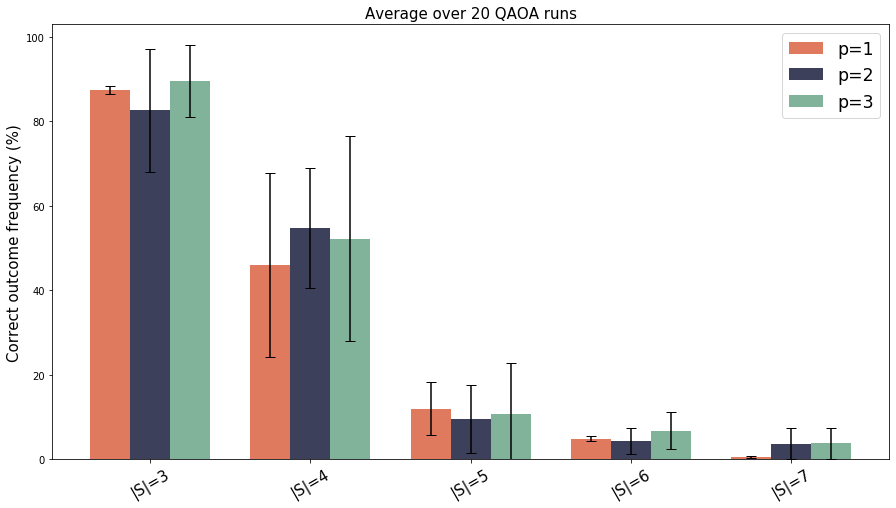

In [12]:
N = 5

p1 = [avg_result[j][0] for j in range(N)]
err1 = [error_result[j][0] for j in range(N)]

p2 = [avg_result[j][1] for j in range(N)]
err2 = [error_result[j][1] for j in range(N)]

p3 = [avg_result[j][2] for j in range(N)]
err3 = [error_result[j][2] for j in range(N)]

width = 0.25
ind = np.arange(N)

fig, ax = plt.subplots(figsize = [15,8])

layer1 = ax.bar(ind, p1, width, color='#e07a5f',yerr=err1,ecolor = 'k', capsize = 5)
layer2 = ax.bar(ind+width, p2, width, color='#3d405b',yerr=err2,ecolor = 'k', capsize = 5)
layer3 = ax.bar(ind+2*width, p3, width, color='#81b29a',yerr=err3,ecolor = 'k', capsize = 5)


ax.set_ylabel('Correct outcome frequency (%)', fontsize = 15)
ax.set_title('Average over 20 QAOA runs', fontsize = 15)
ax.set_xticks(ind + width)
ax.set_xticklabels(('|S|=3', '|S|=4', '|S|=5', '|S|=6', '|S|=7'),rotation = 30, fontsize = 15)
ax.set_ylim(ymin=0)

ax.legend((layer1[0], layer2[0],layer3[0]), ('p=1', 'p=2','p=3'),fontsize = 'xx-large')

plt.show()

As expected, the number of times the correct answer is measured decreases with system size. On one hand the increasing amount of available states unavoidably leads to the correct state being measured in lower amounts. On the other hand, as the system grows in size the energy landscape becomes increasingly complex. Thus, finding the optimal seeds for the QAOA angles and further optimizing angles becomes a more complicated task. It is then to be expected for our code to struggle more for larger sizes. Of course, in the end, what matters is not necessarily what the overall frequency outcome of the correct answer is, but how the frequency ranks with respect to the other set of states.

Below, we address this by displaying the percentage of times the sets were correctly partitioned, i.e. whether the correct answer ranked among the top 5 most measured states in the simulation.

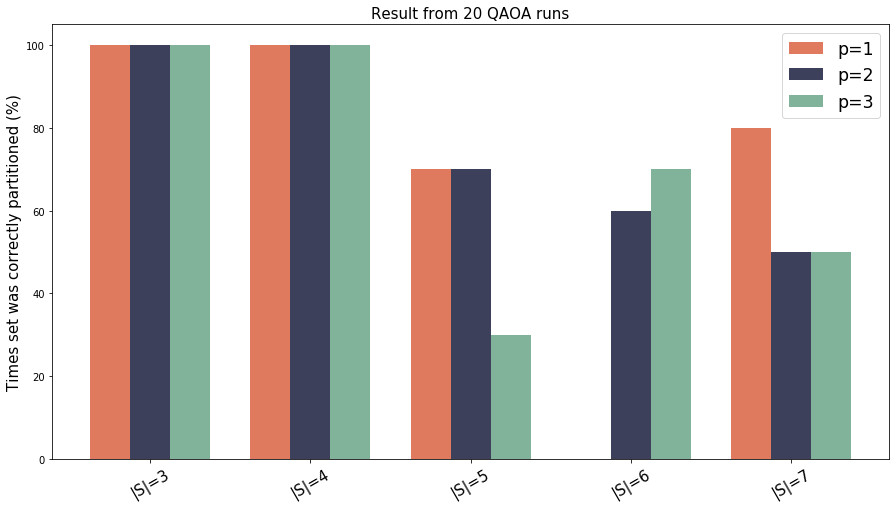

In [19]:
N = 5

per1 = per_result[0]
per2 = per_result[1]
per3 = per_result[2]

width = 0.25
ind = np.arange(N)

fig, ax = plt.subplots(figsize = [15,8])

layer1 = ax.bar(ind, per1, width, color='#e07a5f')
layer2 = ax.bar(ind+width, per2, width, color='#3d405b')
layer3 = ax.bar(ind+2*width, per3, width, color='#81b29a')

ax.set_ylabel('Times set was correctly partitioned (%)', fontsize = 15)
ax.set_title('Result from 20 QAOA runs', fontsize = 15)
ax.set_xticks(ind + width)
ax.set_xticklabels(('|S|=3', '|S|=4', '|S|=5', '|S|=6', '|S|=7'), rotation = 30, fontsize = 15)
ax.set_ylim(ymin=0)
ax.legend((layer1[0], layer2[0],layer3[0]), ('p=1', 'p=2','p=3'),fontsize = 'xx-large')

plt.show()

For smaller sizes we find that the set was always correctly partitioned, but it becomes a trickier task for larger sizes.

Specifically, for the last three cases on the right, we fail to see a consistent improvement for an increasing amount of QAOA layers. While for higher $p$ the ansatz becomes more expressive and capable of reproducing the real ground state, it comes at the *high* price of having to search and optimize a larger parameter space for the QAOA angles. Indeed, the grid search method approach to find the best seed for the classical optimization yields a highly varying set of results for each different value of $p$. This means that the grid search is not capable of finding an optimal seed consistently, due to number of grid points (in addition to the intrisic stochastic nature of the simulations) simply being too few. One could use a finer grid, thus expecting an improvement, but of course that comes at a higher and higher computational cost.

Next, we outline a few possible solutions to this issue and mention other interesting approaches to further ehance the quality of our solver.

# Outlook

There are other interesting avenues that have not been explored here which could contribute to an improved performance of our algorithm:

- Fixing one spin in the system to a specific value would reduce the the problem size by one and would break the $\mathbb{Z}_{2}$ symmetry thus lifting the state degeneracy. The Hamiltonian effectively becomes an all-to-all interacting system of reduced size in the presence of an external field. Note that this requires to expand the parameter search in the $\beta$ direction. 


- It would be interesting to explore if there are improvements from choosing grid points at random instead of using a regular grid. Both that case and the current approach could benefit from fast grid searches accompanied by some averaging process over them to obtain an optimal seed. Additionally, in the spirit of the type of parameters found in [4], it could also prove useful to only explore a small range around the parameters found in the previous layer instead of searching the entire parameter range at each layer. For specific problems it could also be insightful to show contour plots of the landscape at each layer to gain further understanding on where the optimal solutions might be located [3].


- Implementing different approaches to create initial seeds for the classical optimization.  Both the INTERP and FOURIER heuristic approaches in [4] could lead to more consistent and overall better results. 